In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load Model and tokenizers
tokenizer = AutoTokenizer.from_pretrained("yash3056/Llama-3.2-1B-imdb")
model = AutoModelForSequenceClassification.from_pretrained("yash3056/Llama-3.2-1B-imdb", num_labels=2) #n is the number of labels in the code
model.model.config._attn_implementation = "eager"

C:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from lrp import lrp_engine, checkpoint_hook

In [4]:
handle = model.model.embed_tokens.register_forward_hook(checkpoint_hook)

In [5]:
model.to("cuda:0")

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128001)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((20

In [6]:
prompt = "I hated this movie. BOO!"
input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"]

In [7]:
output = model(input_ids.to("cuda:0"))

In [8]:
try:
    checkpoint_vals, topo_exec_order, out_adj_list, fcn_map = lrp_engine(output.logits)
except ValueError:
    curnode, rout, in_adj_list, out_adj_list, e = lrp_engine(output.logits)

In [9]:
# Check results diff between 1st pass and 2nd pass on same input (should be ~0)
[
    ((c1 - c2)**2).sum()
    for (c1, c2) in zip(checkpoint_vals, checkpoint_vals1)
]

NameError: name 'checkpoint_vals1' is not defined

In [9]:
from promise import Promise
promises = list(Promise.start_nodes_to_promise.keys())
len(promises)

211

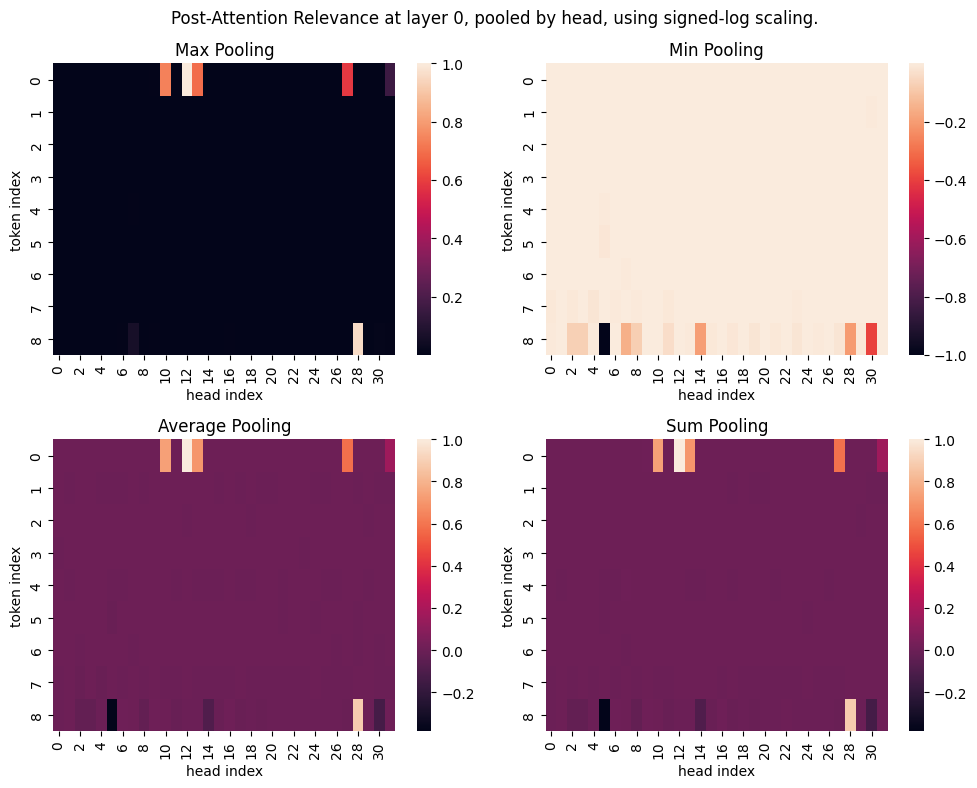

In [15]:
# Visualizing relevance of attention mechanism
import seaborn as sns
import matplotlib.pyplot as plt

# Set this to which layer you want to see
layer_ind = 0

# Use pooling with kernel size and stride set to d_head = d_model / num_heads = 64 (for DNABERT2)
max_pool = torch.nn.MaxPool1d(kernel_size=64, stride=64)
min_pool = lambda x: -max_pool(-x)
avg_pool = torch.nn.AvgPool1d(kernel_size=64, stride=64)
sum_pool = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)

pools = {
    "Max Pooling": max_pool,
    "Min Pooling": min_pool,
    "Average Pooling": avg_pool,
    "Sum Pooling": sum_pool,
}

fig, axs = plt.subplots((len(pools) + 1) // 2, 2, figsize=(10,8))
fig.subplots_adjust(top=1.0)

for i, (pool_name, pool_layer) in enumerate(list(pools.items())):
    # Make a heatmap for each type of pooling
    checkpoint_output = pool_layer(checkpoint_vals[layer_ind])
    lrp_shape = checkpoint_output.shape
    raw_heatmap = checkpoint_output.view((lrp_shape[-2], lrp_shape[-1])).nan_to_num(0.0)
    normed = raw_heatmap.sign() * torch.log1p(raw_heatmap.abs())
    normed /= torch.max(normed.abs())
    sns.heatmap(normed.cpu(), ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(pool_name)
    axs[i // 2, i % 2].set_xlabel("head index")
    axs[i // 2, i % 2].set_ylabel("token index")

# Remove overflow subplot
if i < ((len(pools) + 1) // 2) * 2 - 1:
    axs[i // 2, 1].set_axis_off()
fig.suptitle(f"Post-Attention Relevance at layer {layer_ind}, pooled by head, using signed-log scaling.")
fig.tight_layout()

plt.show()